In [135]:
%matplotlib inline
import matplotlib.pylab as pylab

import pymc3 as mc
from theano.tensor import switch

import pandas as pd
import numpy as np
import datetime

## Generate Test Data

In [95]:
def GaussFunction(wavelength_array, amplitude, centroid, sigma, *args, **kwargs):
    return amplitude * np.exp(-0.5 * ((wavelength_array - centroid) / sigma)**2)

def VoigtAbsorption(tau_array):
    return np.exp(-tau_array)

In [96]:
wavelength_array = np.arange(5010, 5030, 0.02) 

In [97]:
clouds = pd.DataFrame({'cloud': pd.Series([], dtype='str'),
                       'amplitude': pd.Series([], dtype='float'),
                       'centroid': pd.Series([], dtype='float'),
                       'sigma': pd.Series([], dtype='float'),
                       'tau': pd.Series([], dtype='object')})

clouds = clouds.append({'cloud': '0', 'amplitude': 0.85, 'centroid': 5017.5, 'sigma': 1.2, 'tau':[]}, ignore_index=True)
clouds = clouds.append({'cloud': '1', 'amplitude': 0.35, 'centroid': 5018.1, 'sigma': 0.7, 'tau':[]}, ignore_index=True)
clouds = clouds.append({'cloud': '2', 'amplitude': 0.55, 'centroid': 5016.5, 'sigma': 0.9, 'tau':[]}, ignore_index=True)

In [98]:
clouds.set_value(0, 'tau', GaussFunction(wavelength_array, clouds.ix[0]['amplitude'], 
                                         clouds.ix[0]['centroid'], clouds.ix[0]['sigma']))

clouds.set_value(1, 'tau', GaussFunction(wavelength_array, clouds.ix[1]['amplitude'],
                                         clouds.ix[1]['centroid'], clouds.ix[1]['sigma']))

clouds.set_value(2, 'tau', GaussFunction(wavelength_array, clouds.ix[2]['amplitude'],
                                         clouds.ix[2]['centroid'], clouds.ix[2]['sigma']))

,amplitude,centroid,cloud,sigma,tau
0,0.85,5017.5,0,1.2,"[2.79965699376e-09, 3.10658696677e-09, 3.44620..."
1,0.35,5018.1,1,0.7,"[2.94100415831e-30, 4.09167800104e-30, 5.68791..."
2,0.55,5016.5,2,0.9,"[2.59331557443e-12, 3.04403553945e-12, 3.57132..."


In [99]:
onesigmaerror = 0.02 
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

flux_array = VoigtAbsorption(sum(clouds['tau'])) + noise

(0, 1.1)

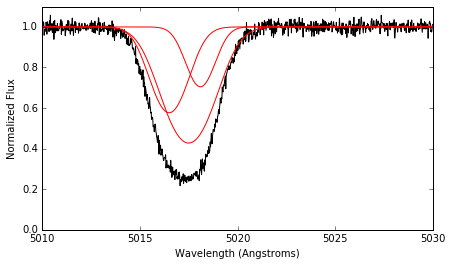

In [100]:
f, ax = pylab.subplots(figsize=(7,4))

ax.plot(wavelength_array, flux_array, color='black', label='flux')

ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[0]['tau']), color='red')
ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[1]['tau']), color='red')
ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[2]['tau']), color='red')

ax.set_ylabel("Normalized Flux")
ax.set_xlabel("Wavelength (Angstroms)")
ax.set_ylim(0, 1.1)

## Fit Model

In [167]:
basic_model = mc.Model()

with basic_model:
    
    height = mc.Uniform("height", 0, 1)
    centroid = mc.Uniform("centroid", wavelength_array[0], wavelength_array[-1])
    sigma = mc.Uniform("sigma", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    
    sd = 1./mc.Uniform("std", 0, 1)**2
    
    mu = GaussFunction(wavelength_array, height, centroid, sigma)
    
    Y_obs = mc.Normal('Y_obs', mu=mu, sd=sd, observed=flux_array)

In [168]:
with basic_model:

    # obtain starting values via MAP
    start = mc.find_MAP()
    
    print(start)

    trace = mc.sample(2000, start=start)

{'centroid_interval_': array(6.068097181409007), 'height_interval_': array(15.137251777204344), 'sigma_interval_': array(18.86909657964602), 'std_interval_': array(2.819757233818673)}


100%|██████████| 2000/2000 [00:28<00:00, 70.15it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa84c55be50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa83d0d3d50>]], dtype=object)

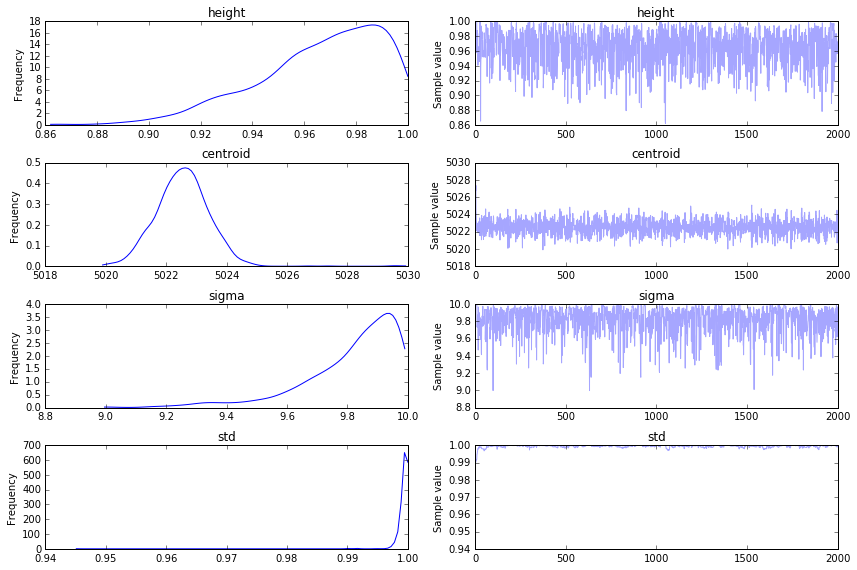

In [169]:
mc.traceplot(trace)

In [138]:
mc.summary(trace)


height:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.967            0.024            0.001            [0.921, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.911          0.952          0.972          0.987          0.999


centroid:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5022.532         0.863            0.017            [5020.901, 5024.145]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5020.920       5021.951       5022.516       5023.095       5024.186


sigma:

  Mean             SD               MC Error         95% HPD interval
  ------------

## Bayes Factor Demo

In [184]:
basic_model = mc.Model()

with basic_model:
    
    # Prior model probabilities
    pi = (0.5, 0.5)

    # Index to true model
    true_model = mc.Bernoulli('true_model', pi[1])
    
    height_1 = mc.Uniform("height_1", 0, 1)
    centroid_1 = mc.Uniform("centroid_1", wavelength_array[0], wavelength_array[-1])
    sigma_1 = mc.Uniform("sigma_1", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    sd_1 = 1./mc.Uniform("std_1", 0, 1)**2
    mu_1 = GaussFunction(wavelength_array, height_1, centroid_1, sigma_1)
    
    height_2 = mc.Uniform("height_2", 0, 1)
    centroid_2 = mc.Uniform("centroid_2", wavelength_array[0], wavelength_array[-1])
    sigma_2 = mc.Uniform("sigma_2", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    sd_2 = 1./mc.Uniform("std_2", 0, 1)**2
    mu_2 = GaussFunction(wavelength_array, height_1, centroid_1, sigma_1)
    
    height_3 = mc.Uniform("height_3", 0, 1)
    centroid_3 = mc.Uniform("centroid_3", wavelength_array[0], wavelength_array[-1])
    sigma_3 = mc.Uniform("sigma_3", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    mu_3 = GaussFunction(wavelength_array, height_1, centroid_1, sigma_1)
    
    Ylike = mc.DensityDist('Ylike',
                lambda value: switch(true_model, 
                    mc.Normal('Y_obs', mu=mu_1, sd=sd_1).dist(height_1).logp(value), 
                    mc.Normal('Y_obs', mu=mu_2, sd=sd_2).dist(height_2).logp(value+1)
                ), observed = flux_array)
    
    trace = mc.sample(100, step=mc.Metropolis())

    mc.summary(trace)

TypeError: For compute_test_value, one input test value does not have the requested type.

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 0, got 1 with shape (1000,).

In [188]:
with mc.Model() as model:

    # Data
    Y = [0,1,2,3,8]

    # Prior model probabilities
    pi = (0.1, 0.9)

    # Index to true model
    true_model = mc.Bernoulli('true_model', pi[1])

    # Poisson mean
    mu = mc.Uniform('mu', 0, 1000)

    # Geometric probability
    p = 1/(1+mu)

    Ylike = mc.DensityDist('Ylike',
            lambda value: switch(true_model, 
                mc.Poisson.dist(mu).logp(value), 
                mc.Geometric.dist(p).logp(value+1)
            ),
            observed=Y)

    trace = mc.sample(20000, step=mc.Metropolis())

    mc.summary(trace[5000:])
    
    p_pois = trace[5000:]['true_model'].mean()  # mean value (i.e. the rate of poisson samples to all samples)
    BF = ((1-p_pois)/p_pois) * (pi[1]/pi[0])  # BayesFactor in favor of poisson model, taking prior probability into account
    
print p_pois
print BF

100%|██████████| 20000/20000 [00:02<00:00, 7539.85it/s]


true_model:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.401            0.490            0.011            [0.000, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          1.000          1.000


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.184            3.169            0.060            [0.993, 9.457]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.520          2.570          3.331          4.606          12.055

0.400666666667
13.462562396
